# Classification of b-quark jets in the Aleph simulated data

Python macro for selecting b-jets (sprays of particles with a b-quark in it) in Aleph Z -> qqbar MC (i.e. simulated decays of the Z0 boson decaying to a quark and an anti-quark) in various ways:
* Initially, simply with "if"-statements making requirements on certain variables. This corresponds to selecting "boxes" in the input variable space (typically called "X"). One could also try a Fisher discriminant (linear combination of input variables), which corresponds to a plane in the X-space. But as the problem is non-linear, it is likely to be sub-optimal.

* Next using Machine Learning (ML) methods. We will during the first week try both (Boosted) Decision Tree ((B)DT) based and Neural Net (NN) based methods, and see how complicated (or not) it is to get a good solution, and how much better it performs compared to the "classic" selection method.

Once you obtain a classification of b-jets vs. non-b-jets, think about how to quantify the quality of your algorithm. Also, try to compare it to the NN result of the Aleph collaboration, given by the variable "nnbjet". It is based on a neural network with 6 input variables (prob_b, spheri, pt2rel, multip, bqvjet, and ptlrel), and two hidden layers each with 10 nodes in. Can you do better?

In the end, this exercise is the simple start on moving into the territory of Machine Learning analysis.


### Data:
The input variables (X) are (where Aleph uses only the first six):
* **prob_b**: Probability of being a b-jet from the pointing of the tracks to the vertex.
* **spheri**: Sphericity of the event, i.e. how spherical it is.
* **pt2rel**: The transverse momentum squared of the tracks relative to the jet axis, i.e. width of the jet.
* **multip**: Multiplicity of the jet (in a relative measure).
* **bqvjet**: b-quark vertex of the jet, i.e. the probability of a detached vertex.
* **ptlrel**: Transverse momentum (in GeV) of possible lepton with respect to jet axis (about 0 if no leptons).
* energy: Measured energy of the jet in GeV. Should be 45 GeV, but fluctuates.
* cTheta: cos(theta), i.e. the polar angle of the jet with respect to the beam axis. Note, that the detector works best in the central region (|cTheta| small) and less well in the forward regions.
* phi:    The azimuth angle of the jet. As the detector is uniform in phi, this should not matter (much).

The target variable (Y) is:
* isb:    1 if it is from a b-quark and 0, if it is not.

Finally, those before you (the Aleph collaboration in the mid 90'ies) produced a Neural Net (6 input variables, two hidden layers with 10 neurons in each, and 1 output varible) based classification variable, which you can compare to (and compete with?):
* nnbjet: Value of original Aleph b-jet tagging algorithm, using only the last six variables (for reference).


### Task:
Thus, the task before you is to produce functions (non-ML and then ML algorithm), which given the input variables X provides an output variable estimate, Y_est, which is "closest possible" to the target variable, Y. The "closest possible" is left to the user to define in a _Loss Function_, which we will discuss further. In classification problems (such as this), the typical loss function to use "Cross Entropy", see https://en.wikipedia.org/wiki/Cross_entropy.

Once you have results, you're welcome to continue with a Fisher Linear Discriminant, and you may also challenge yourself by considering "v1" of the data, which is a little less "polished and ready". If you also manage this, then don't hold back in applying a real ML algorithm to the problem (you can get inspiration from "ML_MethodsDemos.ipynb" or the vast internet). A suggestion might be XGBoost or LightGBM.

* Author: Troels C. Petersen (NBI)
* Email:  petersen@nbi.dk
* Date:   17th of April 2023

In [1]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import csv
import requests

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import optuna

from optuna.integration import CatBoostPruningCallback

import xgboost

from lightgbm import LGBMModel
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
# from catboost import

Possible other packages to consider:
cornerplot, seaplot, sklearn.decomposition(PCA)

In [2]:
r = np.random
r.seed(42)

SavePlots = False
plt.close('all')

# Evaluate an attempt at classification:

This is made into a function, as this is called many times. It returns a "confusion matrix" and the fraction of wrong classifications.

In [3]:
def evaluate(bquark) :
    N = [[0,0], [0,0]]   # Make a list of lists (i.e. confusion matrix) for counting successes/failures.
    for i in np.arange(len(isb)):
        if (bquark[i] == 0 and isb[i] == 0) : N[0][0] += 1
        if (bquark[i] == 0 and isb[i] == 1) : N[0][1] += 1
        if (bquark[i] == 1 and isb[i] == 0) : N[1][0] += 1
        if (bquark[i] == 1 and isb[i] == 1) : N[1][1] += 1
    fracWrong = float(N[0][1]+N[1][0])/float(len(isb))
    accuracy = 1.0 - fracWrong
    return N, accuracy, fracWrong

# Main program start:

In [42]:
def get_data(file_name='AlephBtag_MC_train_Nev50000.csv'):
    # Get data (with this very useful NumPy reader):
    data = np.genfromtxt(file_name, names=True)    # For faster running
    # data = np.genfromtxt('AlephBtag_MC_train_Nev50000.csv', names=True)   # For more data

    # Kinematics (energy and direction) of the jet:
    energy = data['energy']
    cTheta = data['cTheta']
    phi    = data['phi']

    # Classification variables (those used in Aleph's NN):
    prob_b = data['prob_b']
    spheri = data['spheri']
    pt2rel = data['pt2rel']
    multip = data['multip']
    bqvjet = data['bqvjet']
    ptlrel = data['ptlrel']

    # Aleph's NN score:
    nnbjet = data['nnbjet']

    # Truth variable whether it really was a b-jet or not (i.e. target)
    isb    = data['isb']

    features = pd.DataFrame({
        "prob_b": prob_b,
        "spheri": spheri,
        "pt2rel": pt2rel,
        "multip": multip,
        "bqvjet": bqvjet,
        "ptlrel": ptlrel,
    })

    labels = pd.Series(isb, dtype='int16')
    return features, labels
features, labels = get_data('AlephBtag_MC_train_Nev50000.csv')

# Inspect the data:
Define the histogram range and binning (important - programs are generally NOT good at this):

In [5]:
Nbins = 100
xmin = 0.0
xmax = 1.0

### Make new lists selected based on what the jets really are (b-quark jet or light-quark jet):

In [6]:
prob_b_bjets = prob_b[isb == 1]
prob_b_ljets = prob_b[isb == 0]
bqvjet_bjets = bqvjet[isb == 1]
bqvjet_ljets = bqvjet[isb == 0]

### Produce 1D figures:

/tmp/ipykernel_8765/3242375324.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


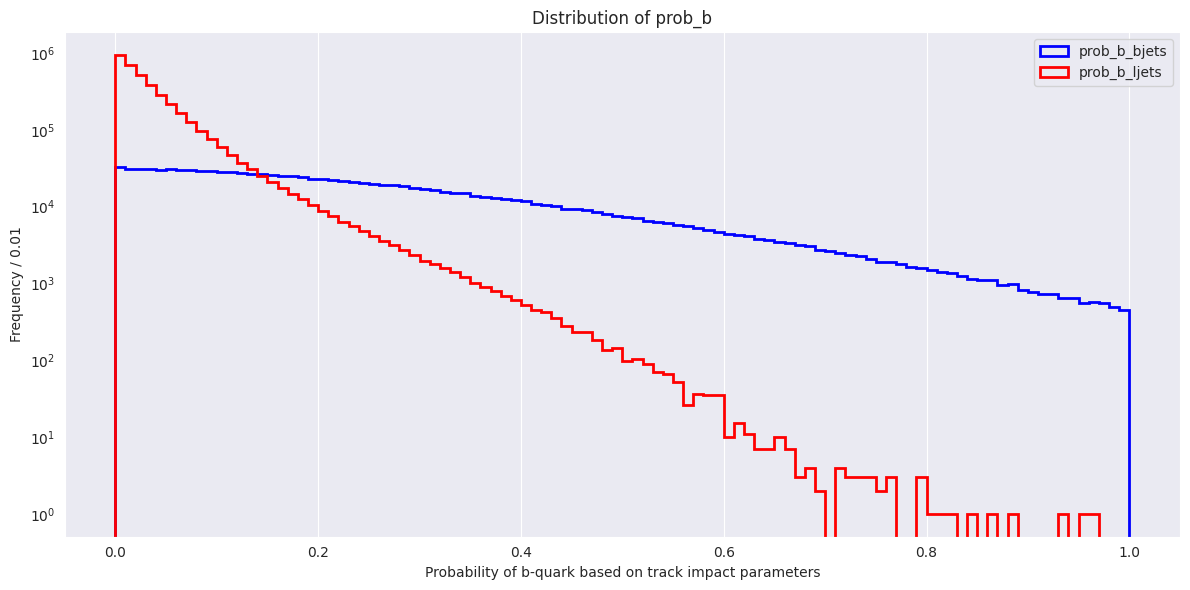

In [7]:
# Produce the actual figure, here with two histograms in it:
fig, ax = plt.subplots(figsize=(12, 6))      # Create just a single figure and axes (figsize is in inches!)
hist_prob_b_bjets = ax.hist(prob_b_bjets, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, label='prob_b_bjets', color='blue')
hist_prob_b_ljets = ax.hist(prob_b_ljets, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, label='prob_b_ljets', color='red')
ax.set_xlabel("Probability of b-quark based on track impact parameters")     # Label of x-axis
ax.set_ylabel("Frequency / 0.01")                                            # Label of y-axis
ax.set_title("Distribution of prob_b")                                       # Title of plot
ax.set_yscale("log")
ax.legend(loc='best')                                                        # Legend. Could also be 'upper right'
ax.grid(axis='y')

fig.tight_layout()
fig.show()

if SavePlots :
    fig.savefig('Hist_prob_b_and_bqvjet.pdf', dpi=600)

### Produce 2D figures:

/tmp/ipykernel_8765/3497247162.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
/tmp/ipykernel_8765/3497247162.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


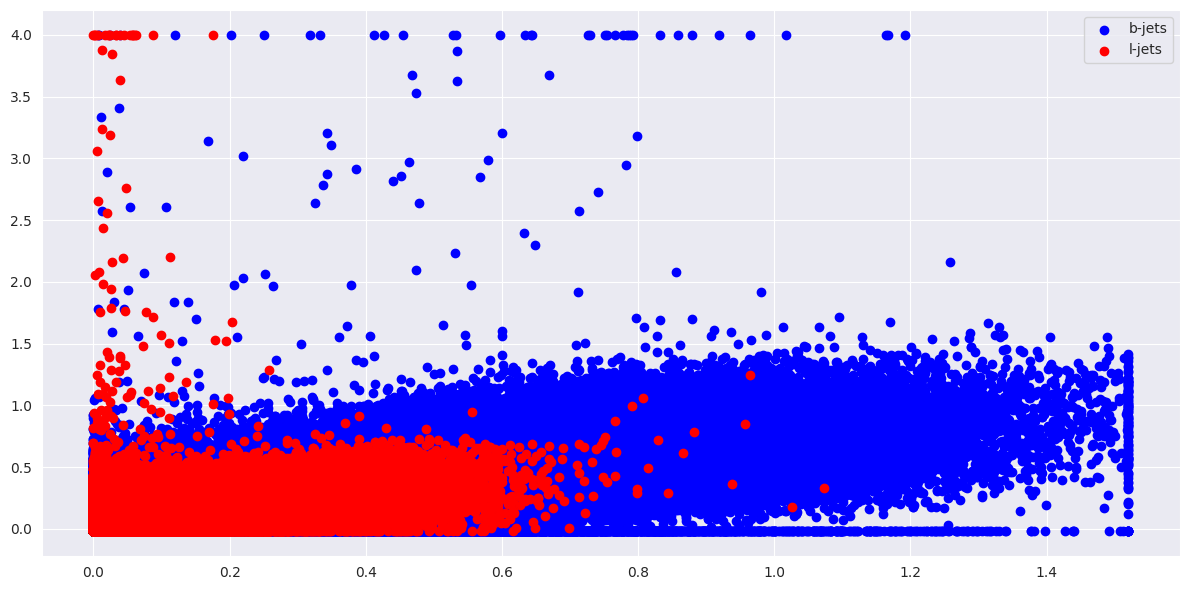

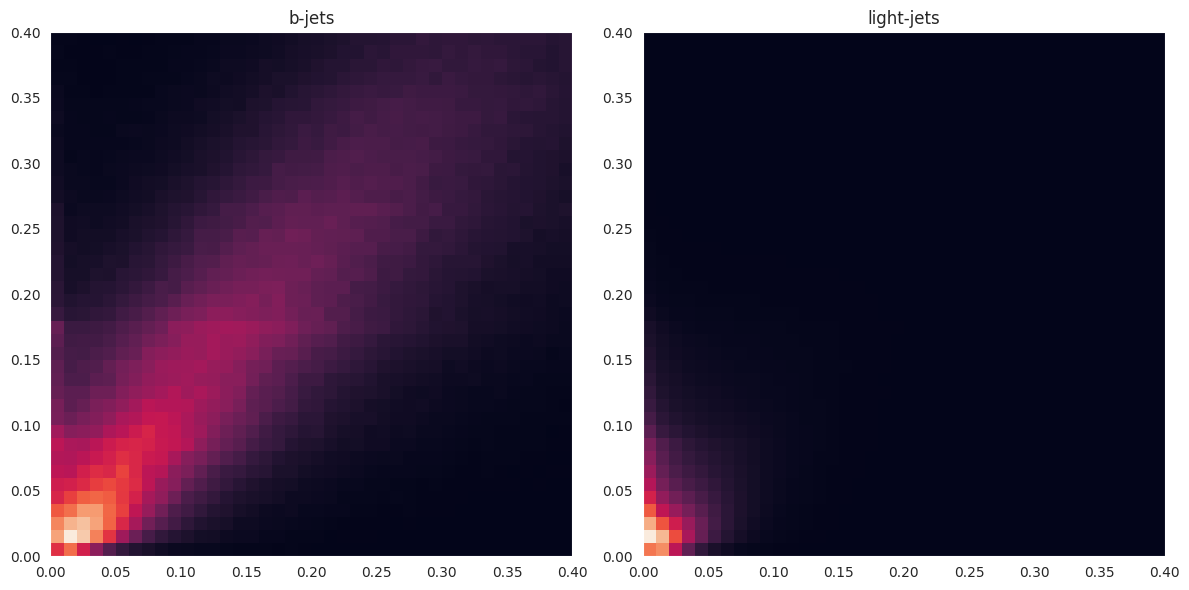

In [8]:
# First we try a scatter plot, to see how the individual events distribute themselves:
fig2, ax2 = plt.subplots(figsize=(12, 6))
scat2_prob_b_vs_bqvjet_bjets = ax2.scatter(prob_b_bjets, bqvjet_bjets, label='b-jets', color='blue')
scat2_prob_b_vs_bqvjet_ljets = ax2.scatter(prob_b_ljets, bqvjet_ljets, label='l-jets', color='red')
ax2.legend(loc='best')
fig2.tight_layout()
fig2.show()

if SavePlots :
    fig2.savefig('Scatter_prob_b_vs_bqvjet.pdf', dpi=600)


# However, as can be seen in the figure, the overlap between b-jets and light-jets is large,
# and one covers much of the other in a scatter plot, which also does not show the amount of
# statistics in the dense regions. Therefore, we try two separate 2D histograms (zoomed):
fig3, ax3 = plt.subplots(1, 2, figsize=(12, 6))
hist2_prob_b_vs_bqvjet_bjets = ax3[0].hist2d(prob_b_bjets, bqvjet_bjets, bins=[40,40], range=[[0.0, 0.4], [0.0, 0.4]])
hist2_prob_b_vs_bqvjet_ljets = ax3[1].hist2d(prob_b_ljets, bqvjet_ljets, bins=[40,40], range=[[0.0, 0.4], [0.0, 0.4]])
ax3[0].set_title("b-jets")
ax3[1].set_title("light-jets")

fig3.tight_layout()
fig3.show()

if SavePlots :
    fig3.savefig('Hist2D_prob_b_vs_bqvjet.pdf', dpi=600)

# Selection:

In [9]:
# I give the selection cuts names, so that they only need to be changed in ONE place (also ensures consistency!):
# Note: This is where you change things (selection values and adding variables) to improve the performance:
cut_bqvjet = 0.20

# Think about how the above cuts "works", and then imagine what I have in mind below, trying to refine the selection:
# cut_propb = 0.15
# loose_propb = 0.07
# tight_propb = 0.26
# loose_bqvjet = 0.09
# tight_bqvjet = 0.34

# If prob_b indicate b-quark, call it a b-quark, otherwise not!
bquark=[]
for i in np.arange(len(prob_b)):
    if (bqvjet[i] > cut_bqvjet) :
        bquark.append(1)
    else :
        bquark.append(0)

### Evaluate the selection:

In [10]:
N, accuracy, fracWrong = evaluate(bquark)
print("\nRESULT OF HUMAN ATTEMPT AT A GOOD SELECTION:")
print("  First number in parenthesis is the estimate, second is the MC truth:")
print("  True-Negative (0,0)  = ", N[0][0])
print("  False-Negative (0,1) = ", N[0][1])
print("  False-Positive (1,0) = ", N[1][0])
print("  True-Positive (1,1)  = ", N[1][1])
print("    Fraction wrong            = ( (0,1) + (1,0) ) / sum = ", fracWrong)
print("    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum = ", accuracy)


RESULT OF HUMAN ATTEMPT AT A GOOD SELECTION:
  First number in parenthesis is the estimate, second is the MC truth:
  True-Negative (0,0)  =  3709772
  False-Negative (0,1) =  500299
  False-Positive (1,0) =  144988
  True-Positive (1,1)  =  644941
    Fraction wrong            = ( (0,1) + (1,0) ) / sum =  0.1290574
    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum =  0.8709426


### Compare with NN-approach from 1990'ies:

In [11]:
bquark=[]
for i in np.arange(len(prob_b)):
    if nnbjet[i] > 0.82:
        bquark.append(1)
    else:
        bquark.append(0)

N, accuracy, fracWrong = evaluate(bquark)
print("\nALEPH BJET TAG:")
print("  First number in parenthesis is the estimate, second is the MC truth:")
print("  True-Negative (0,0)  = ", N[0][0])
print("  False-Negative (0,1) = ", N[0][1])
print("  False-Positive (1,0) = ", N[1][0])
print("  True-Positive (1,1)  = ", N[1][1])
print("    Fraction wrong            = ( (0,1) + (1,0) ) / sum = ", fracWrong)
print("    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum = ", accuracy)


ALEPH BJET TAG:
  First number in parenthesis is the estimate, second is the MC truth:
  True-Negative (0,0)  =  3721065
  False-Negative (0,1) =  357752
  False-Positive (1,0) =  133695
  True-Positive (1,1)  =  787488
    Fraction wrong            = ( (0,1) + (1,0) ) / sum =  0.0982894
    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum =  0.9017106


# Suggested problems:

1. Start by plotting the six "Aleph classification variables" for signal and background, and see which seems to separate most. Possibly draw ROC curves for all of these separately, to quantify this.

2. As you can see, the Aleph-NN performs significantly better. Try to optimize your cuts, combining several of them in smart ways. You may also want to make a linear combination (i.e. Fisher Linear Discriminant) to do better. Challenge yourself to push it as far as you can (well, for say 30 minutes).

3. Does including more data (50000 instead of 5000 events) help your performance?

4. Currently, the scoring (also called the loss function) is simply done by considering the fraction of wrong estimates. Think about what the alternatives could be, especially if you were to give a continuous score like the Aleph-NN.

# Learning points:

From this exercise you should get a feel for the problem at hand, namely how to separate two populations in a 6-dimensional space. It is hard to imagine, yet with simple cuts you should be able to get "some performance", though never anywhere close to the Aleph-NN. You should learn, that it is hard, but that at least the fact that you have known cases makes you capable of getting that "some performance". And you should of course be able to draw ROC curves to compare performances.

The next steps (i.e. following exercises) are to improve this performance through the use of Machine Learning (ML), and make you capable not only of getting results, but also confident in optimising them, and certainly proficient in interpreting them.

# Example solution(s):

The first thing to do is to plot the data, and also look into how correlated it is:

In [12]:
# 6x6 plot of the variable distributions (diagonal) and their mutual correlations (off-diagonal):
import pandas as pd
df = pd.DataFrame(data)  # Make the data into a DataFrame
df = df.drop(['energy', 'cTheta', 'phi', 'nnbjet'], axis=1)  # Drop the irrelevant variables

import seaborn as sns


In [13]:
# Plot of the variable correlation (here Pearson, i.e. linear):

# First print the correlations for ALL events:
print(df.corr(method='pearson'))

# Divide data into b-jets and non-b-jets:
df_b = df.loc[df['isb'] == 1].drop(['isb'], axis=1)
df_l = df.loc[df['isb'] == 0].drop(['isb'], axis=1)



          prob_b    spheri    pt2rel    multip    bqvjet    ptlrel       isb
prob_b  1.000000  0.186055 -0.028696  0.160825  0.825312  0.180547  0.638658
spheri  0.186055  1.000000 -0.048374  0.230401  0.196397  0.046402  0.245380
pt2rel -0.028696 -0.048374  1.000000  0.318225 -0.025848  0.086783  0.002333
multip  0.160825  0.230401  0.318225  1.000000  0.223989  0.046179  0.208497
bqvjet  0.825312  0.196397 -0.025848  0.223989  1.000000  0.153585  0.617878
ptlrel  0.180547  0.046402  0.086783  0.046179  0.153585  1.000000  0.295077
isb     0.638658  0.245380  0.002333  0.208497  0.617878  0.295077  1.000000


#### Comments on plots:

As can be seen, the variables correlate similarly between the two types of jets. In particular 'prob_b' and 'bqvjet' are very correlated, which is the reason why performance doesn't increase a lot, when both of these powerful variables are included: They hold similar power, which can only be used once!

The variable 'ptlrel' is not very correlated to any other variables, which means that it contributes no matter which other variables are included. Of course in the end, one wants to include all variables.

## Example Solution 1 (simply choose three variables):

In [14]:
#Here starts the example solution!
   
# I give the selection cuts names, so that they only need to be changed in ONE place (also ensures consistency!):
loose_propb = 0.10
tight_propb = 0.16
loose_bqvjet = 0.12
tight_bqvjet = 0.28
loose_ptlrel = 0.40
tight_ptlrel = 0.60

bquark=[]
for i in np.arange(len(prob_b)):
    if   (prob_b[i] > tight_propb)  : bquark.append(1)
    elif (bqvjet[i] > tight_bqvjet) : bquark.append(1)
    elif (ptlrel[i] > tight_ptlrel) : bquark.append(1)
    elif ((prob_b[i] > loose_propb)  and (bqvjet[i] > loose_bqvjet)) : bquark.append(1)
    elif ((prob_b[i] > loose_propb)  and (ptlrel[i] > loose_ptlrel)) : bquark.append(1)
    elif ((bqvjet[i] > loose_bqvjet) and (ptlrel[i] > loose_ptlrel)) : bquark.append(1)
    elif ((ptlrel[i] > 0.3) and (prob_b[i] > 0.08) and (bqvjet[i] > 0.10)) : bquark.append(1)  # Adds very little!
    else : bquark.append(0)


KeyboardInterrupt



### Evaluate the selection

In [15]:
N, accuracy, fracWrong = evaluate(bquark)
print("\nRESULT OF HUMAN ATTEMPT AT A GOOD SELECTION:")
print("  First number in parenthesis is the estimate, second is the MC truth:")
print("  True-Negative (0,0)  = ", N[0][0])
print("  False-Negative (0,1) = ", N[0][1])
print("  False-Positive (1,0) = ", N[1][0])
print("  True-Positive (1,1)  = ", N[1][1])
print("    Fraction wrong            = ( (0,1) + (1,0) ) / sum = ", fracWrong)
print("    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum = ", accuracy)

IndexError: list index out of range

### Compare with NN-approach from 1990'ies:

In [ ]:
bquark=[]
for i in np.arange(len(prob_b)):
    if   (nnbjet[i] > 0.82) : bquark.append(1)
    else : bquark.append(0)

N, accuracy, fracWrong = evaluate(bquark)
print("\nALEPH BJET TAG:")
print("  First number in parenthesis is the estimate, second is the MC truth:")
print("  True-Negative (0,0)  = ", N[0][0])
print("  False-Negative (0,1) = ", N[0][1])
print("  False-Positive (1,0) = ", N[1][0])
print("  True-Positive (1,1)  = ", N[1][1])
print("    Fraction wrong            = ( (0,1) + (1,0) ) / sum = ", fracWrong)
print("    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum = ", accuracy)

## Comment on Example Solution 1:

I simply chose to simplify the problem by choosing only three variables and then making an "if-elif-else" selection with these, cutting out the regions with most b-quarks in them, and leaving the rest as non-b-quarks. Some of these regions contribute very little.

The choice of three variables is also not simple, because variables may look good, but if they are very correlated with other variables (like "prob_b" and "bqvjet"), then they might not contribute that much in addition. This was also the reason for choosing "ptlrel" as the third variable.

The solution gets a wrong fraction of <b>0.112</b>, which is reasonably good, though not close to the Aleph NN solution of <b>0.0988</b>.

## Solution Example 2 (brute force looping over selection values to get "optimal" selection):

In [ ]:
# Here I make a range of values (min, max) from which I choose (randomly - more on that) from:
range_loose_prob_b = [0.08, 0.11]
range_tight_prob_b = [0.16, 0.21]
range_loose_bqvjet = [0.13, 0.18]
range_tight_bqvjet = [0.28, 0.40]
range_loose_ptlrel = [0.20, 0.40]
range_tight_ptlrel = [0.45, 0.65]

# The current best (i.e. lowest) fraction wrong. Set high initially, and lowered by better selections:
fracWrong_min = 0.999

# Try several times (here 100):
for Ntest in range(100) :

    # Choose random selection and test it:
    loose_prob_b = r.uniform(range_loose_prob_b[0], range_loose_prob_b[1])
    tight_prob_b = r.uniform(range_tight_prob_b[0], range_tight_prob_b[1])
    loose_bqvjet = r.uniform(range_loose_bqvjet[0], range_loose_bqvjet[1])
    tight_bqvjet = r.uniform(range_tight_bqvjet[0], range_tight_bqvjet[1])
    loose_ptlrel = r.uniform(range_loose_ptlrel[0], range_loose_ptlrel[1])
    tight_ptlrel = r.uniform(range_tight_ptlrel[0], range_tight_ptlrel[1])

    bquark=[]
    for i in np.arange(len(prob_b)):
        if   (prob_b[i] > tight_prob_b) : bquark.append(1)
        elif (bqvjet[i] > tight_bqvjet) : bquark.append(1)
        elif (ptlrel[i] > tight_ptlrel) : bquark.append(1)
        elif ((prob_b[i] > loose_prob_b) and (bqvjet[i] > loose_bqvjet)) : bquark.append(1)
        elif ((prob_b[i] > loose_prob_b) and (ptlrel[i] > loose_ptlrel)) : bquark.append(1)
        elif ((bqvjet[i] > loose_bqvjet) and (ptlrel[i] > loose_ptlrel)) : bquark.append(1)
        else : bquark.append(0)

    N, accuracy, fracWrong = evaluate(bquark)

    # Flag/print best selection(s):
    if (fracWrong < fracWrong_min) :
        print("\nRESULT OF TESTING MANY SELECTION CUTS:")
        print("  First number is my estimate, second is the MC truth:", Ntest)
        print("  True-Negative (0,0)  = ", N[0][0])
        print("  False-Negative (0,1) = ", N[0][1])
        print("  False-Positive (1,0) = ", N[1][0])
        print("  True-Positive (1,1)  = ", N[1][1])
        print("    Fraction wrong            = ( (0,1) + (1,0) ) / sum = ", fracWrong)
        print("    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum = ", accuracy)           

        fracWrong_min = fracWrong
        print("  GOT A NEW MINIMUM.... GREAT!")
        print("  loose_prob_b = ", loose_prob_b)
        print("  tight_prob_b = ", tight_prob_b)
        print("  loose_bqvjet = ", loose_bqvjet)
        print("  tight_bqvjet = ", tight_bqvjet)
        print("  loose_ptlrel = ", loose_ptlrel)
        print("  tight_ptlrel = ", tight_ptlrel)


## Comments on example solution 2:

This solution simply expands on the first solution by searching for better parameters of the first solution. There are six parameters, and one can either do nested loops over all six, or... choose points at random! We'll discuss these approaches more.

This solution improves the wrong fraction from <b>0.112</b> to <b>0.1078</b>, which is marginally better, though still not close to the Aleph NN solution of <b>0.0988</b>.

## Example solution 3 (Decision Tree):

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree,export_graphviz
import pandas as pd
import graphviz
from IPython.display import SVG
from graphviz import Source
from sklearn import tree
from ipywidgets import interactive
from IPython.display import display

In [ ]:
data_xx = np.column_stack((prob_b,spheri,pt2rel,multip,bqvjet,ptlrel))
data_yy = isb
X = pd.DataFrame(data_xx, columns=['prob_b', 'spheri','pt2rel','multip','bqvjet','ptlrel'])
y = pd.Series(data_yy, name='b-quark')

In [ ]:
def plot_tree(depth, Nmin):
    tree_clf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=Nmin)
    tree_clf.fit(X, y)
    graph = Source(tree.export_graphviz(tree_clf, out_file=None, filled = True))
    display(SVG(graph.pipe(format='svg')))
    return tree_clf

In [ ]:
decision_plot = interactive(plot_tree, depth=(1,7), Nmin=(1,50))
display(decision_plot)

In [ ]:
tree_clf = DecisionTreeClassifier(max_depth=7, min_samples_leaf=25)
tree_clf.fit(X, y)

N, accuracy, fracWrong = evaluate(bquark)
print("\nDecision Tree BJET TAG:")
print("  First number in parenthesis is the estimate, second is the MC truth:")
print("  True-Negative (0,0)  = ", N[0][0])
print("  False-Negative (0,1) = ", N[0][1])
print("  False-Positive (1,0) = ", N[1][0])
print("  True-Positive (1,1)  = ", N[1][1])
print("    Fraction wrong            = ( (0,1) + (1,0) ) / sum = ", fracWrong)
print("    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum = ", accuracy)

## Comment on example solution 3:

This solution - a Decision Tree (from SKlearn) - is fundamentally different, as it is mostly automated, though it is still simple. However, 

improves the wrong fraction from <b>0.112</b> to <b>0.1078</b>, which is marginally better, though still not close to the Aleph NN solution of <b>0.0988</b>.

In [39]:
def objective_cat(trial: optuna.Trial, labels=labels, features=features) -> float:
    labels = pd.Series(labels, dtype='float')
    train_x, valid_x, train_y, valid_y = train_test_split(features, labels, test_size=0.25)

    param = {
        "loss_function": "Logloss",
        "task_type": "GPU",
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS", "Poisson"]),
        "used_ram_limit": "8gb",
    }

    gbm = CatBoostClassifier(**param)

    gbm.fit(
        train_x,
        train_y,
        eval_set=[(valid_x, valid_y)],
        verbose=0,
        early_stopping_rounds=100,
    )

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)

    return accuracy


def objective_xgb(trial: optuna.Trial):
    train_x, valid_x, train_y, valid_y = train_test_split(features, labels, test_size=0.25)

    param = {
        "verbosity": 1,
        "objective": "binary:logistic",
        "eval_metric": 'auc',
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "auc")
    xgb = XGBClassifier(**param, early_stopping_rounds=100, callbacks=[pruning_callback])
    xgb.fit(
        train_x,
        train_y,
        eval_set=[(valid_x, valid_y)],
        verbose=0,
    )

    # evoke pruning manually.
    pruning_callback.check_pruned()

    preds = xgb.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)

    return accuracy


def optimize_model(obj=objective_cat):
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
        direction="maximize",
    )
    study.optimize(obj, n_trials=100, timeout=600, show_progress_bar=True)
    print(f"Number of finished trials: {len(study.trials)}")
    print(f"Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print(f"  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    return study


labels = pd.Series(labels, dtype='float16')
optimize_model(obj=objective_cat)
print("\n\n")
# optimize_model(obj=objective_xgb)
# print("\n\n")
# optimize_model(obj=objective_lgbm)

[I 2023-04-30 09:30:19,510] A new study created in memory with name: no-name-a83a9e7a-54a7-4a1a-ae06-6be68861445a
/home/amh/Documents/coding/GitHub/AppliedML2023/venv/lib/python3.10/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-04-30 09:30:30,541] Trial 0 finished with value: 0.9056 and parameters: {'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.9056.
[I 2023-04-30 09:30:32,847] Trial 1 finished with value: 0.90456 and parameters: {'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.9056.
[I 2023-04-30 09:30:36,226] Trial 2 finished with value: 0.90544 and parameters: {'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.9056.
[I 2023-04-30 09:31:20,560] Trial 3 finished with value: 0.90336 and parameters: {'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.9056.
[I 2023-04-30 09:31:22,274] Trial 4 finished with value: 0.90376 and parameters: {'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Poisson'}. Best is trial 0 with value: 0.9056.
[I 2023-04-30 09:32:39,167] Trial 5 finished with value: 0.9072 

In [43]:
best_params = {"loss_function": "Logloss",
               "task_type": "GPU",
               'depth': 4,
               'boosting_type': 'Plain',
               'bootstrap_type': 'Bernoulli'}
clf = CatBoostClassifier(**best_params)
features, labels = get_data('../data/AlephBtag_MC_train_Nev5000000.csv')
clf.fit(features, labels)

Learning rate set to 0.021102
0:	learn: 0.6715085	total: 48.4ms	remaining: 48.3s
1:	learn: 0.6509235	total: 96.9ms	remaining: 48.4s
2:	learn: 0.6316137	total: 145ms	remaining: 48.2s
3:	learn: 0.6132711	total: 193ms	remaining: 48s
4:	learn: 0.5960530	total: 241ms	remaining: 47.9s
5:	learn: 0.5795463	total: 288ms	remaining: 47.8s
6:	learn: 0.5642529	total: 336ms	remaining: 47.7s
7:	learn: 0.5499234	total: 383ms	remaining: 47.5s
8:	learn: 0.5358211	total: 430ms	remaining: 47.3s
9:	learn: 0.5229481	total: 477ms	remaining: 47.2s
10:	learn: 0.5107913	total: 523ms	remaining: 47s
11:	learn: 0.4990734	total: 569ms	remaining: 46.8s
12:	learn: 0.4883900	total: 614ms	remaining: 46.7s
13:	learn: 0.4775284	total: 661ms	remaining: 46.6s
14:	learn: 0.4674276	total: 707ms	remaining: 46.4s
15:	learn: 0.4582561	total: 752ms	remaining: 46.3s
16:	learn: 0.4496167	total: 798ms	remaining: 46.1s
17:	learn: 0.4412357	total: 845ms	remaining: 46.1s
18:	learn: 0.4331858	total: 891ms	remaining: 46s
19:	learn: 0.42

In [44]:
features_test, labels_test = get_data('../data/AlephBtag_MC_train_Nev500000.csv')
labels_pred = clf.predict(features_test)
print(accuracy_score(labels_pred, labels_test))

0.904092
